In [207]:
from jedi.debug import speed
from mistune.plugins.speedup import speedup
from numba.cuda.libdevice import fmax
from scipy.constants import speed_of_light
%matplotlib inline
from scipy import signal
from scipy.io import wavfile
import scipy.integrate
import IPython.display as ipyd
import librosa
import librosa.display
import librosa.feature
import matplotlib.pyplot as plt
import numpy as np

In [208]:
minHz = 125
maxHz = 3000
stft_frame_len = 0.033
stft_frame_trans = 0.015
mels_amount = 40
n_mfcc = 13


# Comparison Files

In [209]:
def load_plot(path: str):
    #Load and display
    file_sample_rate, file_wav = wavfile.read(path)
    ipyd.display(ipyd.Audio(rate=file_sample_rate, data=file_wav))
    file_n = len(file_wav)

    #plot wav
    plt.figure(figsize=(4,2))
    plt.plot(np.linspace(0, file_n/file_sample_rate, file_n), file_wav)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

    # FFT
    plt.figure(figsize=(4,2))
    file_fft = np.fft.fft(file_wav)[minHz:maxHz]
    file_fft_n = len(file_fft)
    plt.plot(np.linspace(0, file_sample_rate*(file_fft_n - 1)/file_fft_n, file_fft_n), np.abs(file_fft))
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()
    return file_sample_rate, file_wav, file_n, file_fft

In [210]:
def spectrum_stft(wave, sample_rate, should_print = False):
    samples_frame = int(stft_frame_len * sample_rate)
    samples_transition = int(stft_frame_trans * sample_rate)
    wave = wave.astype(np.float32)

    # normalize
    wave /= np.max(np.abs(wave),axis=0)

    stft = librosa.stft(wave, n_fft=samples_frame, hop_length=samples_transition)
    if should_print:
        fig, ax = plt.subplots(figsize=(4, 2))
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft)),
                                 y_axis='hz',
                                 x_axis='time',
                                 ax=ax,
                                 fmax = maxHz,
                                 fmin = minHz )
        plt.show()

    mel_spectrum = librosa.feature.melspectrogram(
        y=wave, sr=sample_rate, n_mels=n_mfcc,
        n_fft=samples_frame, hop_length=samples_transition
    )

    log_mel_spectrum = librosa.power_to_db(mel_spectrum)

    mfccs = librosa.feature.mfcc(S=log_mel_spectrum, n_mfcc=mels_amount)

    # 4. Extract C0
    # librosa returns shape (n_mfcc, time_steps), so row 0 is C0.
    c0_energy_profile = mfccs[0]

    #print(c0_energy_profile.min(),  " ", c0_energy_profile.max(), " ", c0_energy_profile.mean())
    if False:
        plt.figure(figsize=(10, 6))
        # 1. Plot the Histogram
        counts, bins, _ = plt.hist(mfccs[0], bins=50, color='gray', alpha=0.7, label='Data Distribution')

        # 2. visual helper
        plt.title("Histogram of C0 (Log Energy)")
        plt.xlabel("C0 Value (Loudness)")
        plt.ylabel("Frequency (Count of Frames)")
        plt.grid(axis='y', alpha=0.5)

        plt.show()

    if should_print:
        fig, ax = plt.subplots(figsize=(4, 2))
        print(log_mel_spectrum.shape)
        librosa.display.specshow(log_mel_spectrum,
                                 y_axis='hz',
                                 x_axis='time',
                                 ax=ax,
                                 fmax = maxHz,
                                 fmin = minHz )
        plt.show()

    if should_print:
        fig, ax = plt.subplots(figsize=(4, 2))
        print(log_mel_spectrum.shape)
        librosa.display.specshow(mfccs,
                                 y_axis='hz',
                                 x_axis='time',
                                 ax=ax,
                                 fmax = maxHz,
                                 fmin = minHz )
        plt.show()

    return mfccs


In [211]:
def diff_fft(a: np.ndarray, b: np.ndarray, sample_rate: int) -> np.ndarray:

    # diff add
    plt.figure(figsize=(4,2))
    n = len(a)
    x = np.linspace(0, sample_rate*(n - 1)/n, n)
    curve = np.abs(np.abs(a)*4 - np.abs(b))
    plt.plot(x, curve)
    print(np.trapezoid(curve)/100000)

    plt.xlabel("Frequency")
    plt.ylabel("Difference")
    plt.show()

    plt.plot(x, np.abs(a))
    plt.plot(x, np.abs(b))

    idx = np.argwhere(np.diff(np.abs(a) - np.abs(b))).flatten()
    plt.plot(x[idx], np.abs(a)[idx], 'ro')

    plt.show()

    return idx


## Start

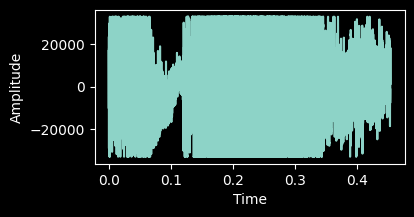

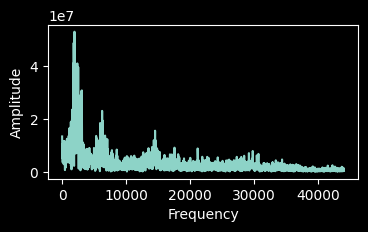

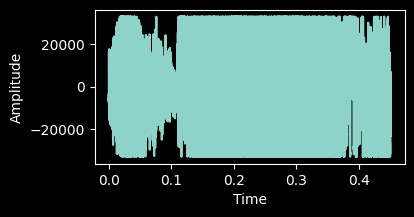

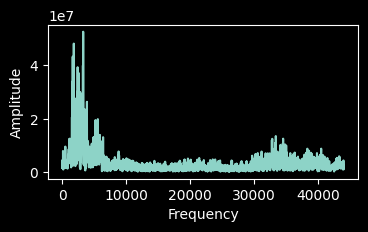

290479.8913680612


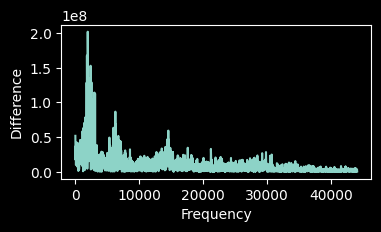

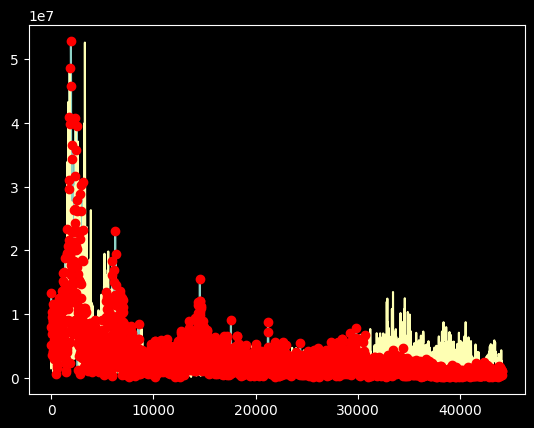

In [212]:
# Load
startFile_sample_rate, startFile_wav, startFile_n, startFile_fft = load_plot("./wav/start.wav")

# load mariusz start
startFileMariusz_sample_rate, startFileMariusz_wav, startFileMariusz_n, startFileMariusz_fft = load_plot("./wav/startMariusz.wav")

diff_fft(startFile_fft, startFileMariusz_fft, startFile_sample_rate)

startFile_mel = spectrum_stft(startFile_wav, startFile_sample_rate)
startFileMariusz_mel= spectrum_stft(startFileMariusz_wav, startFileMariusz_sample_rate)

## Stop

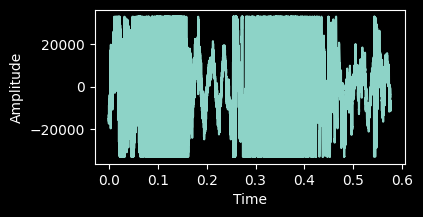

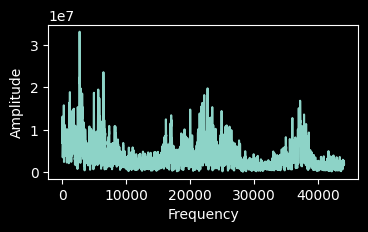

In [213]:
stopFile_sample_rate, stopFile_wav, stopFile_n, stopFile_fft = load_plot("./wav/stop.wav")

stopFile_mel = spectrum_stft(stopFile_wav, stopFile_sample_rate)

## Plus

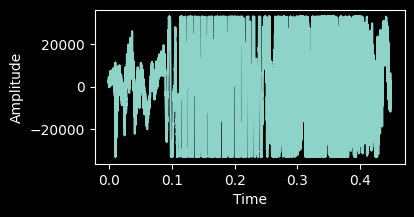

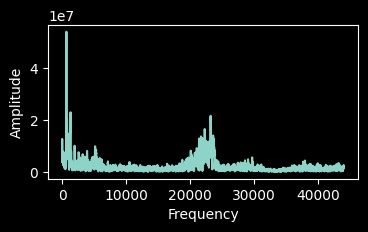

In [214]:
plusFile_sample_rate, plusFile_wav, plusFile_n, plusFile_fft = load_plot("./wav/plus.wav")

plusFile_mel = spectrum_stft(plusFile_wav, plusFile_sample_rate)


## Minus

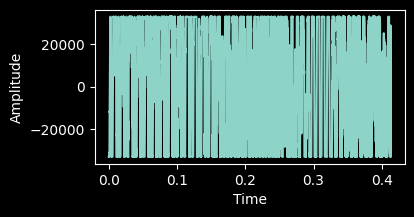

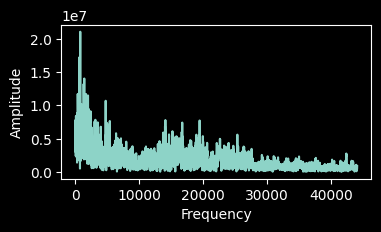

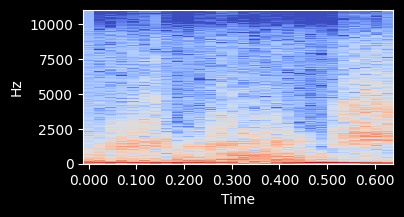

(13, 28)


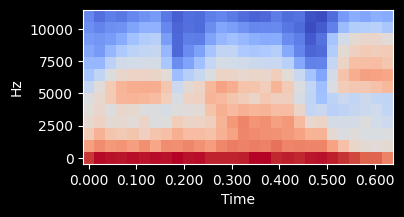

(13, 28)


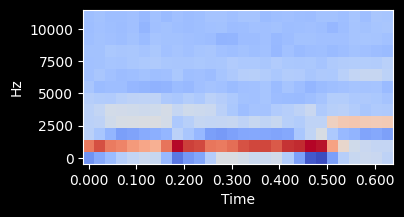

In [215]:
minusFile_sample_rate, minusFile_wav, minusFile_n, minusFile_fft = load_plot("./wav/minus.wav")

minusFile_mel = spectrum_stft(minusFile_wav, minusFile_sample_rate, True)


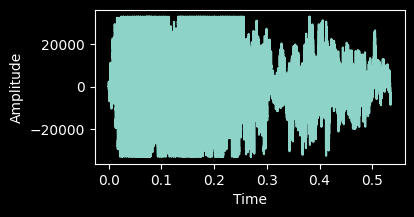

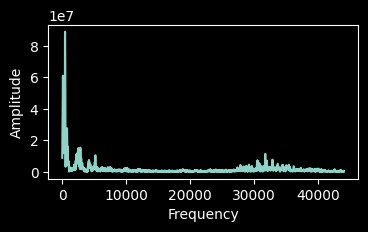

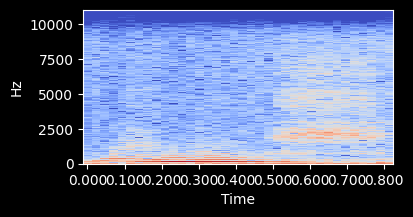

(13, 36)


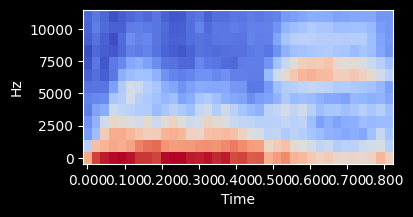

(13, 36)


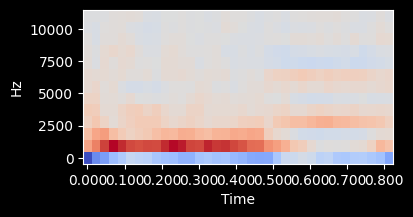

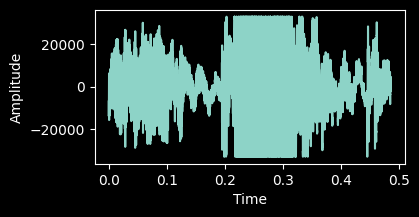

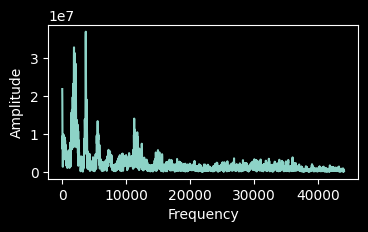

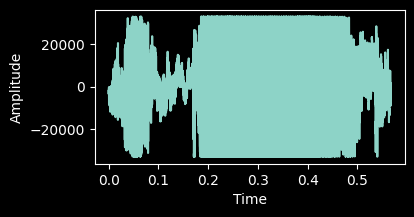

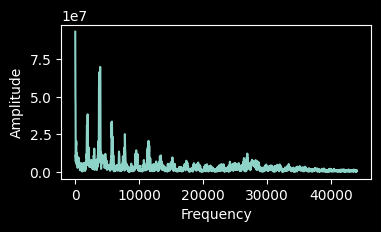

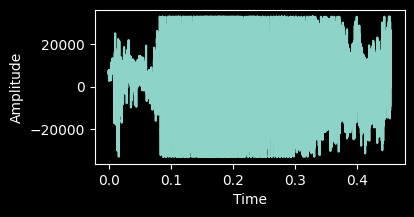

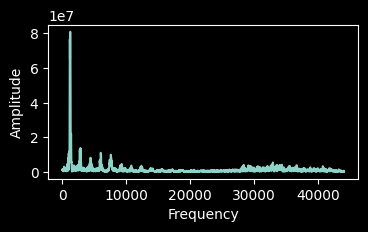

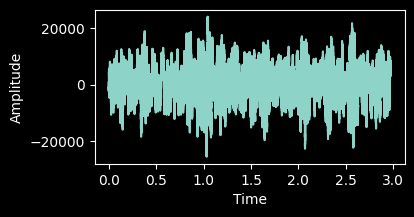

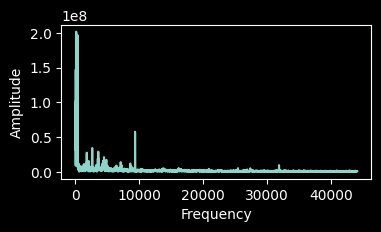

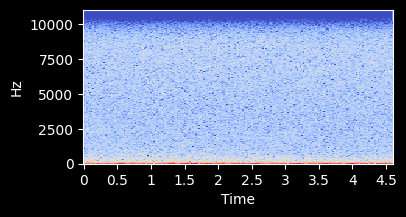

(13, 199)


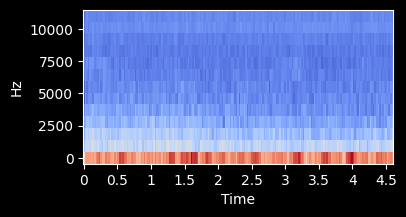

(13, 199)


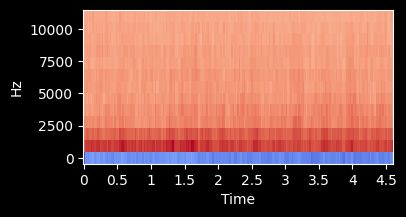

In [216]:
patiMinus_sample_rate, patiMinus_wav, patiMinus_n, patiMinus_fft = load_plot("./wav/patiMinus.wav")
patiMinus_mel = spectrum_stft(patiMinus_wav, patiMinus_sample_rate, True)

patiStop_sample_rate, patiStop_wav, patiStop_n, patiStop_fft = load_plot("./wav/patiStop.wav")
patiStop_mel = spectrum_stft(patiStop_wav, patiStop_sample_rate)

patiStart_sample_rate, patiStart_wav, patiStart_n, patiStart_fft = load_plot("./wav/patiStart.wav")
patiStart_mel = spectrum_stft(patiStart_wav, patiStart_sample_rate)

patiPlus_sample_rate, patiPlus_wav, patiPlus_n, patiPlus_fft = load_plot("./wav/patiPlus.wav")
patiPlus_mel = spectrum_stft(patiPlus_wav, patiPlus_sample_rate)

noice_sample_rate, noice_wav, noice_n, noice_fft = load_plot("./wav/noice.wav")
noice_mel = spectrum_stft(noice_wav, noice_sample_rate, True)

In [217]:
def cosine_dist(a: np.ndarray, b: np.ndarray):
    a = a.T
    b = b.T

    comp_len = min(len(a), len(b))

    distances = np.zeros(comp_len)
    for i in range(comp_len):
        distances[i] = scipy.spatial.distance.cosine(a[i], b[i])

    return np.average(distances)


In [218]:
def find_match(samples, current_mel, speech_threshold):
    best_label = None
    best_dist = float("inf")

    dists = []
    speech_start = -1
    speech_end = -1

    for index in range(len(current_mel) - 1):
        if speech_start == -1 and current_mel[0][index] < speech_threshold <= current_mel[0][index + 1]:
            speech_start = index + 1
        if speech_end == -1 and current_mel[0][index] >= speech_threshold > current_mel[0][index + 1]:
            speech_end = index

    speech_count = 0
    for index in range(len(current_mel) - 1):
        if current_mel[0][index] >= speech_threshold:
            speech_count += 1



    #print(dists)
    if speech_count > 3:
        for mel, label in samples:
            dist = dtw_distance(mel, current_mel)
            dists.append(dist)
            if dist < best_dist:
                best_dist = dist
                best_label = label

        return best_label, best_dist
    else:
        return "noise", -1


In [219]:
from scipy.spatial.distance import cdist

def dtw_distance(mfcc1, mfcc2):
    # Calculate the distance matrix between all time steps
    D = cdist(mfcc1.T, mfcc2.T, metric='euclidean')

    # Use librosa to find the best path (alignment) through the matrix
    # The last value in the accumulated cost matrix is the total "distance"
    D_accum, wp = librosa.sequence.dtw(C=D)

    # Normalize by path length so longer words don't automatically have higher scores
    distance = D_accum[-1, -1] / len(wp)
    return distance

In [220]:
from collections import deque
import pyaudio
import wave

FORMAT = pyaudio.paInt16
CHUNK = int(stopFile_sample_rate * stft_frame_len)
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=1,
                rate=startFile_sample_rate,
                input=True,
                frames_per_buffer=CHUNK)

samples = [(minusFile_mel, "minus"),
           (plusFile_mel, "plus"),
           (stopFile_mel, "stop"),
           (startFile_mel, "start"),
           (patiMinus_mel, "minusP"),
           (patiPlus_mel, "plusP"),
           (patiStart_mel, "startP"),
           (patiStop_mel, "stopP")]


buffer_size = max(len(mel) for mel, _ in samples)

try:
    print("* recording")

    frames = []

    for i in range(buffer_size):
        data = stream.read(CHUNK)
        frames.append(data)

    frames = deque(frames, maxlen=len(frames))
    full_buffer = b''.join(frames) # Join all chunks into one long byte string
    audio_data = np.frombuffer(full_buffer, dtype=np.int16) # Convert bytes to int16 integers
    frames_mel = spectrum_stft(audio_data.astype(np.float32), stopFile_sample_rate)

    noise_sample = frames_mel[0]
    noise_mean = np.mean(noise_sample)
    noise_std = np.std(noise_sample)
    K = 4
    calculated_threshold = noise_mean + (K * noise_std)

    print(f"Noise Floor: {noise_mean:.2f} ({noise_sample.min():.2f}/{noise_sample.max():.2f})")
    print(f"Threshold:   {calculated_threshold:.2f}")

    while True:
        data = stream.read(CHUNK)
        frames.append(data)
        full_buffer = b''.join(frames) # Join all chunks into one long byte string
        audio_data = np.frombuffer(full_buffer, dtype=np.int16) # Convert bytes to int16 integers
        frames_mel = spectrum_stft(audio_data.astype(np.float32), stopFile_sample_rate)

        label, num = find_match(samples, frames_mel, calculated_threshold)

        if label != "noise":
            print(label, " ", num)


finally:
    stream.stop_stream()
    stream.close()
    p.terminate()


* recording
Noise Floor: -184.17 (-197.63/-21.35)
Threshold:   -13.72
minus   17.916253604537218
minus   18.212590521710197
minus   15.143221060244448
minus   15.10577134520589
minus   15.519698843555988
minus   15.602400771918273
minus   15.989552124850151
minus   17.563726175749764
minus   19.438569109946407
minus   20.621057175207056
minus   21.375160761156458
plus   26.191747240217058
plus   27.869329939783345
plus   28.654926622656728
stop   29.135854696835786
stopP   29.64165145405896
stopP   30.09221065191868
stopP   30.00649704911584
stopP   29.671462068400302
minusP   29.193453503249795
minusP   28.066457262998114
minusP   28.440341613527764
minus   19.62918757480221
minus   20.692536447601153
minus   21.5766193535122
minus   21.62090421513323
minus   20.36271410004694
minus   19.34104107909146
minus   19.909711444979443
startP   22.37985561159066
startP   22.79372994771976
startP   24.36739774456492
minus   20.841663752767314
minus   21.416128150039775
minus   22.248222145896

KeyboardInterrupt: 